<a href="https://colab.research.google.com/github/melikesifa/assignments/blob/main/task_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialize

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale

## Load Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
dfBF =  pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv', encoding = "ISO-8859-1")

In [6]:
dfBF.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


## Prepare Data

In [12]:
# Aggregate by customer ID
dfBFA = (dfBF.groupby('User_ID').agg({'Product_ID':'nunique','Purchase':'sum'})
             .rename(columns={'Product_ID':'purchase_count', 'Purchase':'purchase_amt_total'})
            )
dfBFA

,purchase_count,purchase_amt_total
User_ID,,
1000001,35,334093
1000002,77,810472
1000003,29,341635
1000004,14,206468
1000005,106,821001
...,...,...
1006036,514,4116058
1006037,122,1119538
1006038,12,90034


In [13]:
# Scale data

X = dfBFA
X[X.columns] = scale(X[X.columns])

Note that previously we had a 'Target' column named 'y' which is what we used to train our models on.  In those models our learning was *Supervised* by the previously defined Target values.  However, in this dataset, there is no indication of prior grouping of the customers, so we are going to have to learn something about the data in an *Unsupervised Learning* manner.

Text(0, 0.5, 'amt_total')

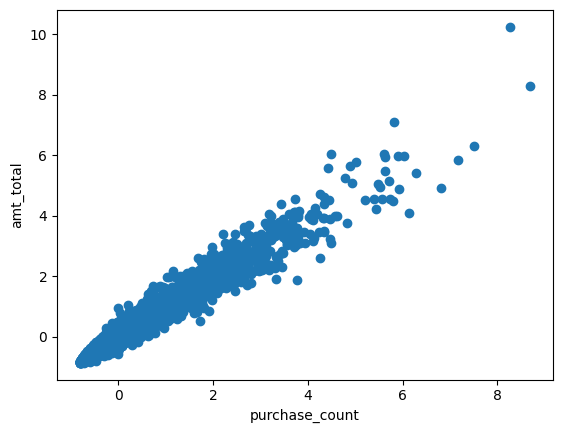

In [14]:
# Visualize scatterplot

plt.scatter(X['purchase_count'],X['purchase_amt_total'])
plt.xlabel('purchase_count')
plt.ylabel('amt_total')

It seems that there is a positive correlation with the total amount and the number of purchases.

### K-Means Clustering

In order to segment the customers, let's start by randomly assigning them to 'n' clusters.  Thereafter, each customer is reassigned to another cluster that it is closer to, and this process is repeated until no more improvements are possible.  This method is known as **K-Means Clustering**.

In [15]:
# Build k-Means Clustering model

from sklearn.cluster import KMeans

mdlKmcBFA = KMeans(n_clusters=3, random_state=1)
mdlKmcBFA.fit(X)
kMeans_labels = mdlKmcBFA.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 1.0, 'K-Means Clustering')

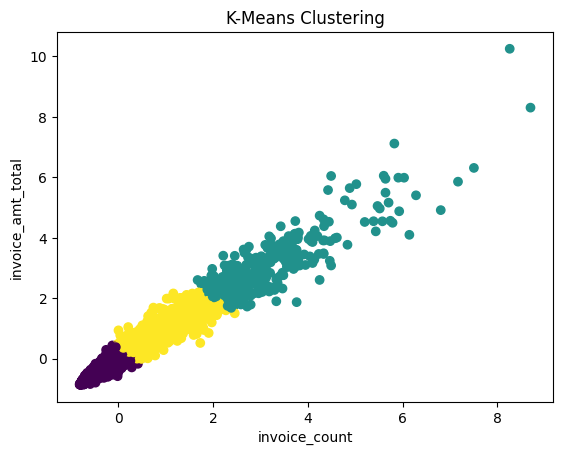

In [17]:
# Display k-Means cluster on scatter plot

plt.scatter(X['purchase_count'],X['purchase_amt_total'],c=kMeans_labels)
plt.xlabel('purchase_count')
plt.ylabel('amt_total')
plt.title('K-Means Clustering')

This clustering was expected since the previous plot showed a clear linear relationship.

In [18]:
# Evaluate quality of clusters
from sklearn.metrics import silhouette_score

silhouette_score(X, mdlKmcBFA.labels_)

0.6652767061197826

Every cluster would have the score of 0.665

In [21]:
# Generate linkages between data points
from scipy.cluster import hierarchy

Z = hierarchy.linkage(X, 'ward')

Text(0.5, 1.0, 'Hierarchical Clustering')

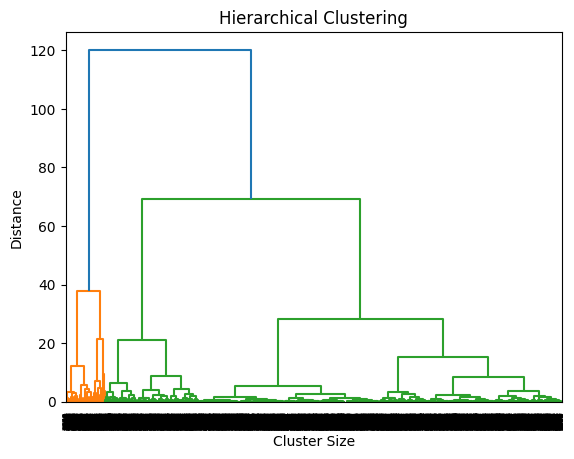

In [22]:
# Visualize Dendrogram of Clusters

hierarchy.dendrogram(Z)
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering')

 the dendrogram shows 3 clusters are ideal,

In [24]:
# Build Hierarchical Clustering model
from sklearn.cluster import AgglomerativeClustering

mdlHrcBFK = AgglomerativeClustering(n_clusters=3)
mdlHrcBFK.fit(X)
hClust_labels = mdlHrcBFK.labels_

In [25]:
silhouette_score(X, mdlHrcBFK.labels_)

0.6415136338507116

Text(0.5, 1.0, 'Hierarchical Clustering')

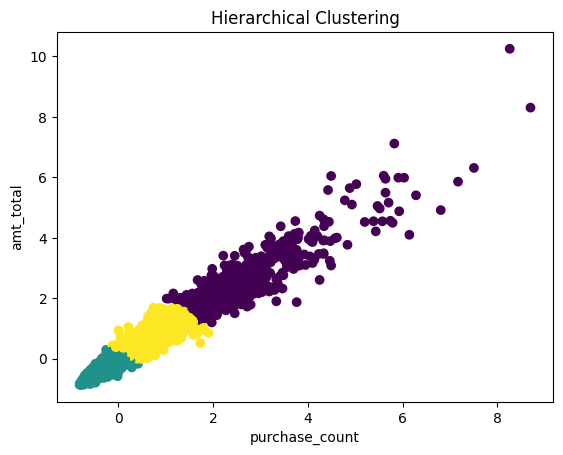

In [27]:
# Display Hierarchical cluster on scatter plot

plt.scatter(X['purchase_count'],X['purchase_amt_total'],c=hClust_labels)
plt.xlabel('purchase_count')
plt.ylabel('amt_total')
plt.title('Hierarchical Clustering')

In [28]:
# Function for Hierarchical Clustering
def cluster_hierarchy(X, k):
    mdlHrcBFK = AgglomerativeClustering(n_clusters=k)
    mdlHrcBFK.fit(X)
    hClust_labels = mdlHrcBFK.labels_
    hClust_sil_score = silhouette_score(X, mdlHrcBFK.labels_)
    return (hClust_labels, hClust_sil_score)

In [29]:
# Iterate over different values of k to determine best silhouette score

for k in [2, 3, 4, 5, 6]:
    hClust_labels, hClust_sil_score = cluster_hierarchy(X,k)
    print('k: ',k,'\t\t', 'Silhouette Score: ', hClust_sil_score)

k:  2 		 Silhouette Score:  0.7454258816188772
k:  3 		 Silhouette Score:  0.6415136338507116
k:  4 		 Silhouette Score:  0.6399901867458228
k:  5 		 Silhouette Score:  0.506267207431757
k:  6 		 Silhouette Score:  0.5070500323467254


It seems the ideal cluster size is '2',

### DBScan Clustering and Anomaly Detection

In [30]:
# Build DBScan model

from sklearn.cluster import DBSCAN

mdlDbsBFA = DBSCAN(eps=0.2)
mdlDbsBFA.fit(X)
dbscan_labels = mdlDbsBFA.labels_

In [31]:
silhouette_score(X, dbscan_labels)

0.6568861530009426

In [32]:
# calculate number of clusters
dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
dbscan_clusters

4

In [33]:
# calculate number of anomalies
dbscan_anomalies = list(dbscan_labels).count(-1)
dbscan_anomalies

60

Text(0.5, 1.0, 'DBScan Clustering')

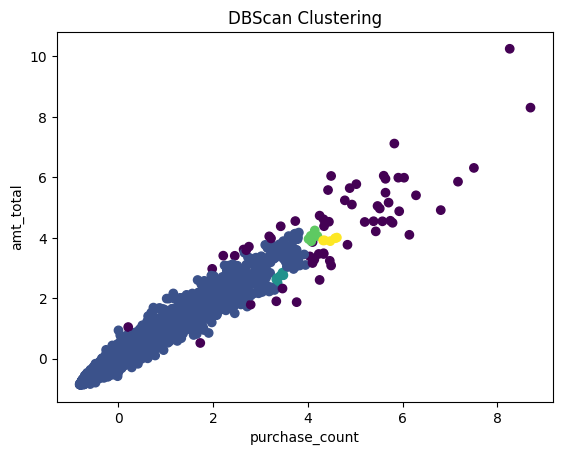

In [35]:
# Display DBScan cluster on scatter plot

plt.scatter(X['purchase_count'],X['purchase_amt_total'],c=dbscan_labels)
plt.xlabel('purchase_count')
plt.ylabel('amt_total')
plt.title('DBScan Clustering')

utexas_ds_orie_divider_gray.png